In [1]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB7

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [2]:
dataset_dir_name = "../MangoLeafBD Dataset"

# Get the current directory of the Python script
current_directory = os.getcwd()

# Construct the full path to the CSV file
data_dir = os.path.join(current_directory, dataset_dir_name)
ds_name = 'Mango Leaf Disease'

In [3]:
# Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [4]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    
    return df

df = create_df(filepaths, labels)

In [5]:
df.head()

,filepaths,labels
0,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose
1,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose
2,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose
3,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose
4,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose


In [6]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")
    
num_of_examples(df, ds_name)

The Mango Leaf Disease dataset has 4000 images.


In [7]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

The Mango Leaf Disease dataset has 8 classes


In [8]:
def classes_count(df, name='df'):
    
    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)
        
classes_count(df, ds_name)

The Mango Leaf Disease dataset has: 

Class 'Anthracnose' has 500 images
----------------------------------------------------------------------
Class 'Bacterial Canker' has 500 images
----------------------------------------------------------------------
Class 'Cutting Weevil' has 500 images
----------------------------------------------------------------------
Class 'Die Back' has 500 images
----------------------------------------------------------------------
Class 'Gall Midge' has 500 images
----------------------------------------------------------------------
Class 'Healthy' has 500 images
----------------------------------------------------------------------
Class 'Powdery Mildew' has 500 images
----------------------------------------------------------------------
Class 'Sooty Mould' has 500 images
----------------------------------------------------------------------


In [9]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "bar"}, {'type': 'pie'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=20),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors)),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    
    
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

In [10]:
def check_null_values(df, name='df'):
    
    num_null_vals = sum(df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"The {name} dataset has no null values")
    
    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        

check_null_values(df, ds_name)

The Mango Leaf Disease dataset has no null values


In [11]:
df.head()

,filepaths,labels
0,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose
1,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose
2,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose
3,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose
4,d:\AI-Practical-Tasks\2023-2024\final\Group D\...,Anthracnose


In [12]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [13]:
def num_imgs(df, name='df'):
    print(f"Number of {name} dataset is {len(df)} images")

In [14]:
num_imgs(train_df, 'Training '+ds_name)
num_imgs(valid_df, 'Validation '+ds_name)
num_imgs(test_df, 'Testing '+ds_name)

Number of Training Mango Leaf Disease dataset is 2800 images
Number of Validation Mango Leaf Disease dataset is 600 images
Number of Testing Mango Leaf Disease dataset is 600 images


In [15]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Mango Leaf Disease dataset has 8 classes
The Validation Mango Leaf Disease dataset has 8 classes
The Testing Mango Leaf Disease dataset has 8 classes


In [16]:
classes_count(train_df, 'Training '+ds_name)

The Training Mango Leaf Disease dataset has: 

Class 'Die Back' has 354 images
----------------------------------------------------------------------
Class 'Powdery Mildew' has 353 images
----------------------------------------------------------------------
Class 'Cutting Weevil' has 348 images
----------------------------------------------------------------------
Class 'Anthracnose' has 365 images
----------------------------------------------------------------------
Class 'Gall Midge' has 365 images
----------------------------------------------------------------------
Class 'Sooty Mould' has 343 images
----------------------------------------------------------------------
Class 'Bacterial Canker' has 322 images
----------------------------------------------------------------------
Class 'Healthy' has 350 images
----------------------------------------------------------------------


In [17]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Mango Leaf Disease dataset has: 

Class 'Bacterial Canker' has 95 images
----------------------------------------------------------------------
Class 'Anthracnose' has 70 images
----------------------------------------------------------------------
Class 'Healthy' has 75 images
----------------------------------------------------------------------
Class 'Die Back' has 67 images
----------------------------------------------------------------------
Class 'Cutting Weevil' has 78 images
----------------------------------------------------------------------
Class 'Sooty Mould' has 84 images
----------------------------------------------------------------------
Class 'Powdery Mildew' has 70 images
----------------------------------------------------------------------
Class 'Gall Midge' has 61 images
----------------------------------------------------------------------


In [18]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Mango Leaf Disease dataset has: 

Class 'Anthracnose' has 65 images
----------------------------------------------------------------------
Class 'Sooty Mould' has 73 images
----------------------------------------------------------------------
Class 'Cutting Weevil' has 74 images
----------------------------------------------------------------------
Class 'Bacterial Canker' has 83 images
----------------------------------------------------------------------
Class 'Die Back' has 79 images
----------------------------------------------------------------------
Class 'Healthy' has 75 images
----------------------------------------------------------------------
Class 'Powdery Mildew' has 77 images
----------------------------------------------------------------------
Class 'Gall Midge' has 74 images
----------------------------------------------------------------------


In [19]:
# crobed image size
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col = 'filepaths', 
                                       y_col= 'labels', 
                                       target_size = img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


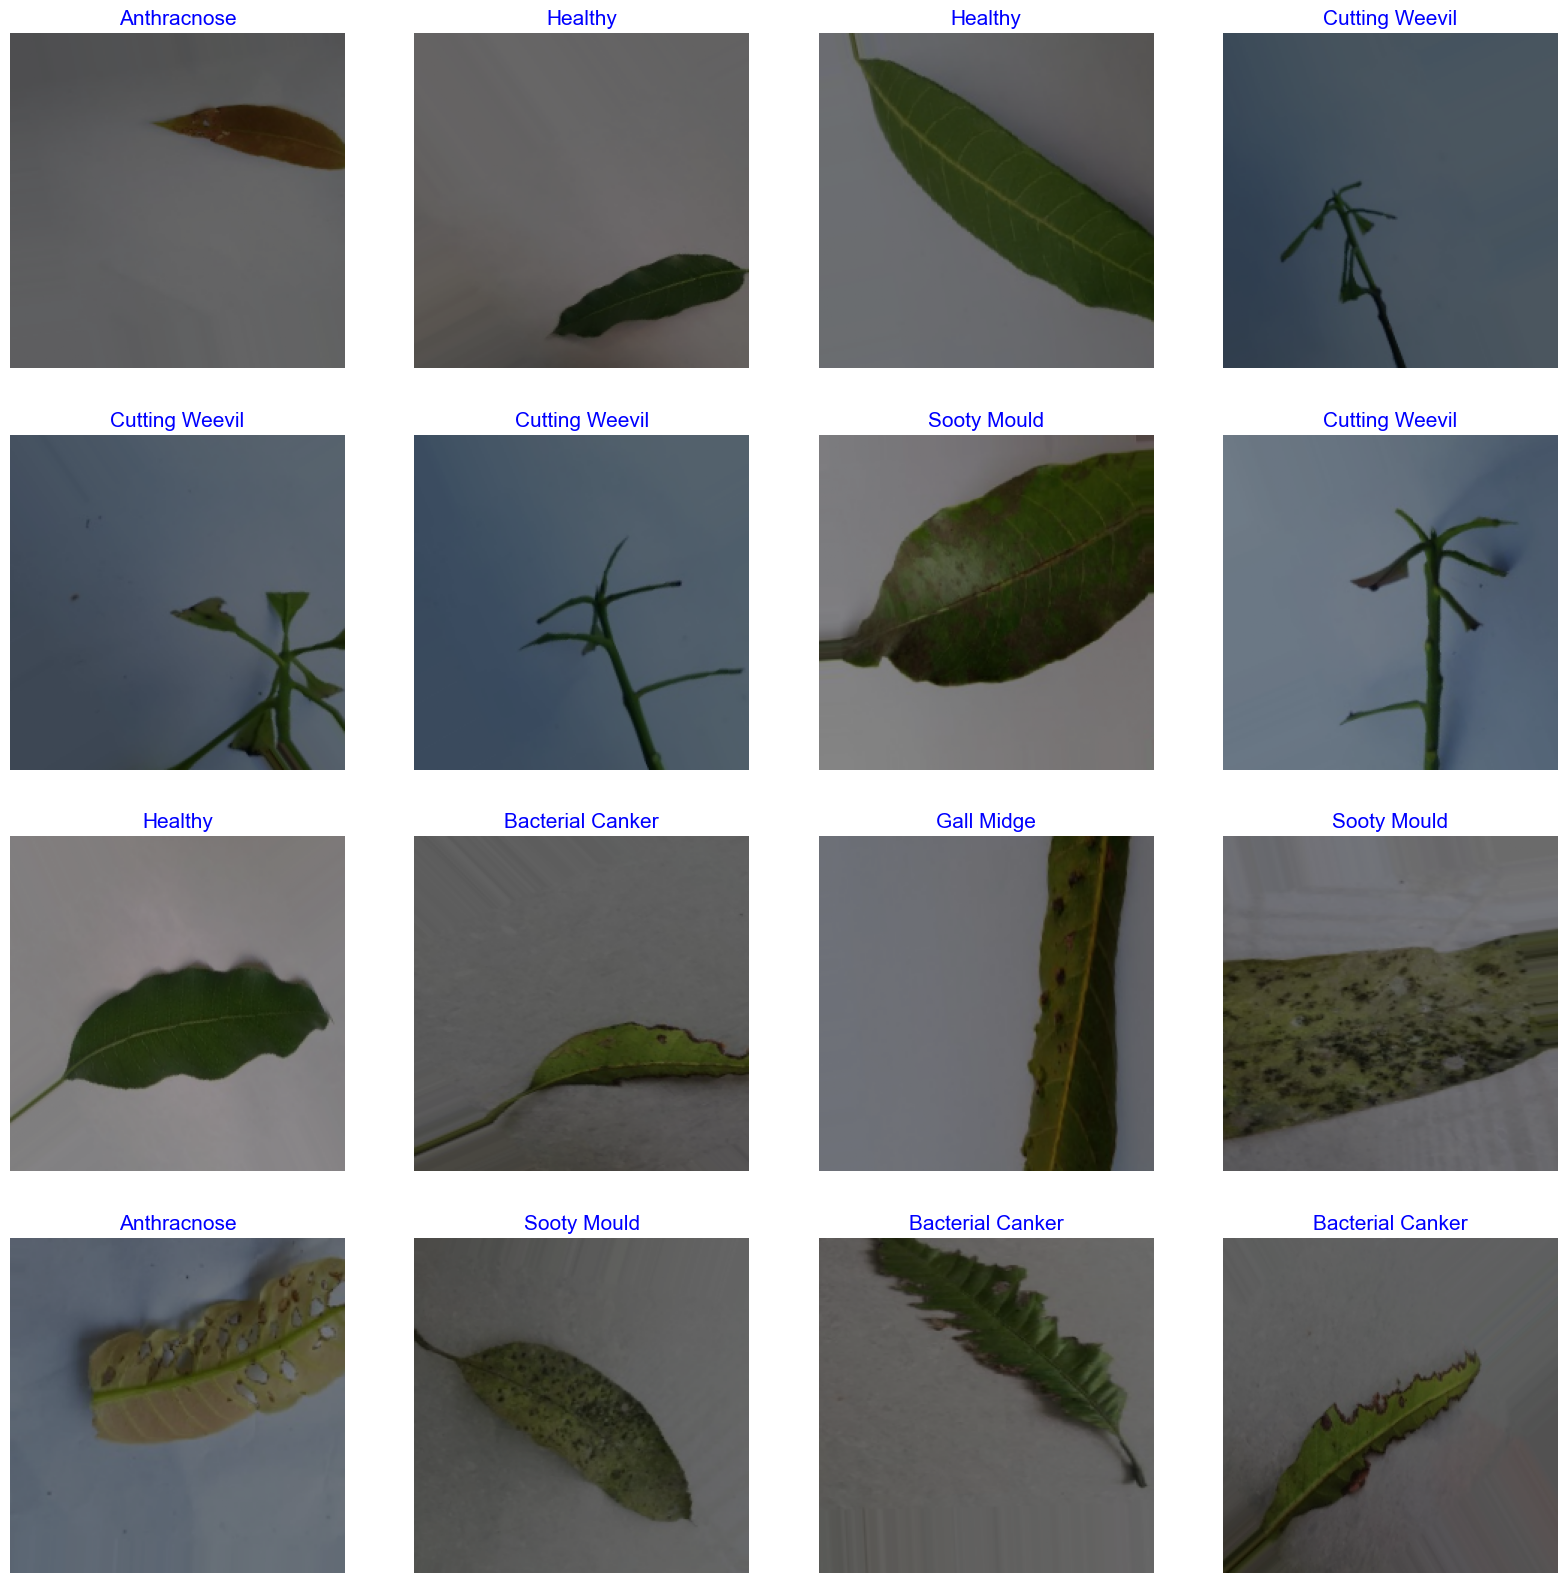

In [20]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 15)
    plt.axis('off')
    
plt.show()

In [21]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb7 from EfficientNet family.

base_model = tf.keras.applications.EfficientNetV2L(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128,kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation = 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()



 43606016/473176280 [=>............................] - ETA: 7:51

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


# Implement the learning rate scheduler
lr_scheduler = LearningRateScheduler(scheduler)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True,
                               mode='min',
                              )

In [ ]:
batch_size = 16   # set batch size for training
epochs = 50   # number of all epochs in training

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping,lr_scheduler])

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
model.save_weights('my_model_weights_v2l.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted disease: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('/kaggle/working/my_model_weights.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = list(train_gen.class_indices.keys())

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Anthracnose/20211008_124253 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)


In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Bacterial Canker/IMG_20211106_120951 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Cutting Weevil/20211011_160708 (Custom) (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Die Back/20211129_160627 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Gall Midge/IMG_20211106_161226 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Healthy/20211231_123625 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Powdery Mildew/20211109_121452 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/MangoLeafBD Dataset/Sooty Mould/IMG_20211108_121234 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)